In [1]:
%matplotlib inline
import cv2
import json
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from seggradcam.visualize_sgc import SegGradCAMplot
from seggradcam.dataloaders import Cityscapes
from seggradcam.training_write import TrainingParameters, TrainingResults
from seggradcam.training_plots import plot_predict_and_gt, plot_loss, plot_metric
from seggradcam.seggradcam import SegGradCAM, SuperRoI, ClassRoI, PixelRoI, BiasRoI
from seggradcam.visualize_sgc import SegGradCAMplot


In [2]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    
    image = img[:,:256]
    mask = img[:,256:]
    
    return image, mask

In [3]:
def addColors(gg):
        im = np.zeros([gg.shape[0],gg.shape[1],3],dtype=np.uint8)
        for i in range(gg.shape[0]):
             for u in range(gg.shape[1]):
                if gg[i,u]==0:
                        im[i,u]=np.array( [7.97324365,  100.09284559, 3.3311774 ])# np.array([106.90082868, 139.99479298,  36.44992868]) #dirty-green
                if gg[i,u]==12:
                        im[i,u]= np.array([125.15370551, 128.00683271, 102.70661342]) 
                if gg[i,u]==11:
                        im[i,u]= np.array( [205.10936684, 155.91383531, 158.10853995])
                if gg[i,u]==10:
                        im[i,u]= np.array([202.89782929,  26.40039899,  61.60446492])
                if gg[i,u]==9:
                        im[i,u]= np.array([ 69.55103943,  70.40548991,  69.17557542])#road
                if gg[i,u]==8:
                        im[i,u]=np.array( [127.97324365,  63.09284559, 127.3311774 ])
       
                if gg[i,u]==7:
                        im[i,u]=np.array([ 76.50791694, 126.13882776, 172.87875815]) #sky
                if gg[i,u]==6:
                        im[i,u]=np.array( [157.75659272, 245.35283586, 155.30654771]) #road-dividers
                if gg[i,u]==4:
                        im[i,u]=np.array([ 80.53963208,   6.04446257,  71.14193837]) #buildings
                if gg[i,u]==5:
                        im[i,u]= np.array( [  3.55582649,   3.56494346, 136.37082893])#vehicles
                if gg[i,u]==3:
                        im[i,u]=np.array( [237.59908029,  39.26874128, 225.79570494])
                if gg[i,u]==2:
                        im[i,u]=np.array([  4.1605802 ,   3.27185434,   6.7030066 ])
                if gg[i,u]==1:
                        im[i,u]=np.array( [214.7472683 , 206.44713466,  33.15308545])
                #if gg[i,u]==0:
                 #       im[i,u]=np.array([0,128,0])
        return im

In [4]:
def heatmap(image, from_layer, to_layer, cls):
    prop_from_layer = model.layers[from_layer].name
    prop_to_layer = model.layers[to_layer].name
    roi=PixelRoI(20,210,image)
    pixsgc = SegGradCAM(model, image, cls, prop_to_layer, prop_from_layer, roi=roi, normalize=True, abs_w=False, posit_w=False)
    pixsgc.SGC()
    plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
    plotter.explainPixel()

In [5]:
def heatmap_random(image, from_layer, to_layer, cls):
    initial_weights = model.get_weights()
    new_weights = initial_weights.copy()
    new_weights[to_layer] = np.random.uniform(size = initial_weights[to_layer].shape)
    new_model = model
    new_model.set_weights(new_weights)
    
    prop_from_layer = new_model.layers[from_layer].name
    prop_to_layer = new_model.layers[to_layer].name
    # ROI is a pixel in this experiment
    roi=PixelRoI(20,210,image)
    pixsgc = SegGradCAM(new_model, image, cls, prop_to_layer, prop_from_layer, roi=roi,
                 normalize=True, abs_w=False, posit_w=False)
    # compute SegGradCAM
    pixsgc.SGC()
    # create an object with plotting functionality
    plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=new_model)
    # plot explanations on 1 picture
    plotter.explainPixel()

In [6]:
#model = keras.models.load_model('resnet50')
#model = keras.models.load_model('unet')
model = keras.models.load_model('vgg_unet')

In [7]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

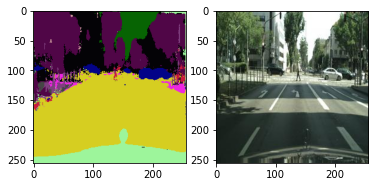

In [8]:
m='16.jpg'
folder_path = 'heatmaps'
valid_folder="cityscapes_data/val"
m,tru=LoadImage(m, valid_folder)
i=np.asarray(m)
#i = cv2.resize(inp,(256,256),interpolation = cv2.INTER_AREA)
i=i.reshape((1,256,256,3))
r=model.predict(i)
r=r.reshape((256,256,-1))
s=addColors(np.argmax(r, axis=-1))
plt.subplot(1,2,1)
plt.imshow(s)
plt.subplot(1,2,2)
plt.imshow(m)

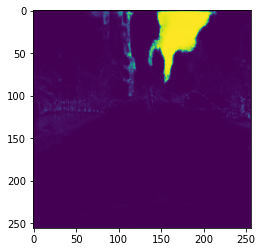

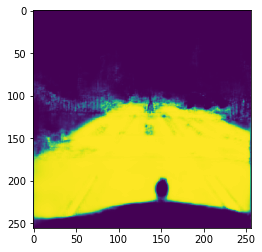

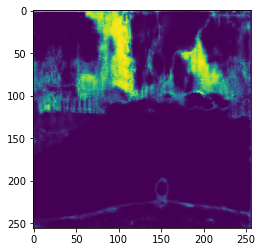

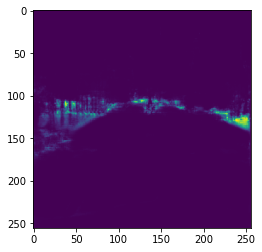

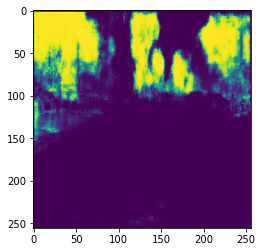

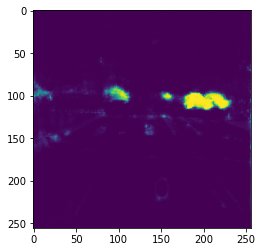

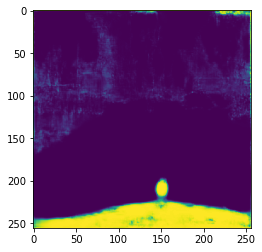

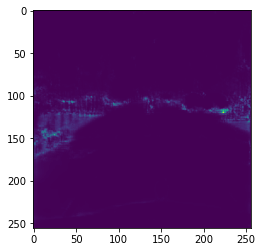

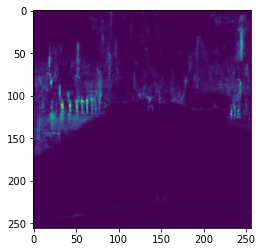

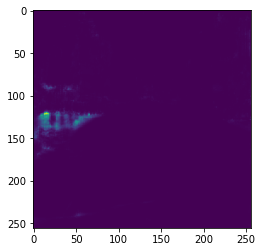

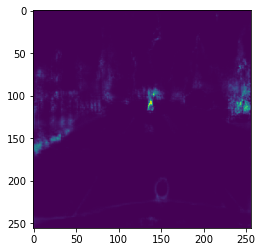

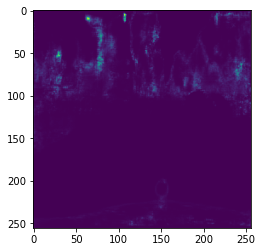

In [9]:
m = [np.float32(x) for x in m]
m = np.array(m)
img_tensor = np.expand_dims(m, 0)
output = model.predict(img_tensor)
for i in range(12):
    plt.imshow(output[:,:,:,i].squeeze())
    plt.show()

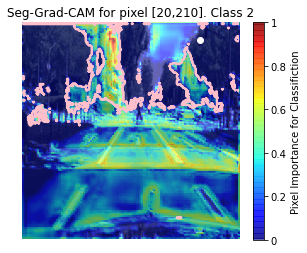

In [10]:
heatmap(m, -1, -3, 2)

In [11]:
#plt.imshow(m/255.)
#print(m.shape)

In [12]:
#Plot 4 images: original, ground truth, predicted mask, seg-grad-cam explanations for a selected single pixel
#plotter.pixelGtPrediction()

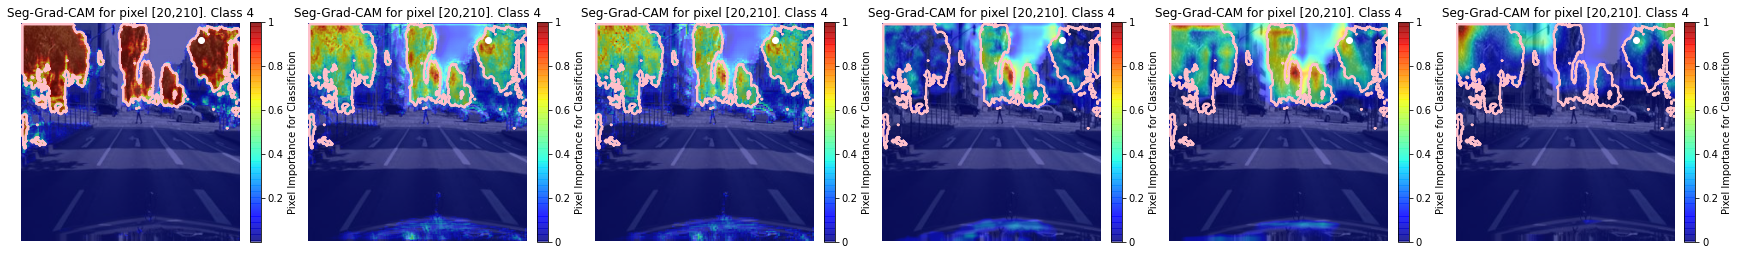

In [13]:
## initial_weights = model.get_weights()
plt.figure(figsize=(30,30))
plt.subplot(1,6,1)
heatmap(m, -1, -1, 4)
plt.subplot(1,6,2)
heatmap(m, -1, -2, 4)
plt.subplot(1,6,3)
heatmap(m, -1, -3, 4)
plt.subplot(1,6,4)
heatmap(m, -1, -10, 4)
plt.subplot(1,6,5)
heatmap(m, -1, -15, 4)
plt.subplot(1,6,6)
heatmap(m, -1, -20, 4)

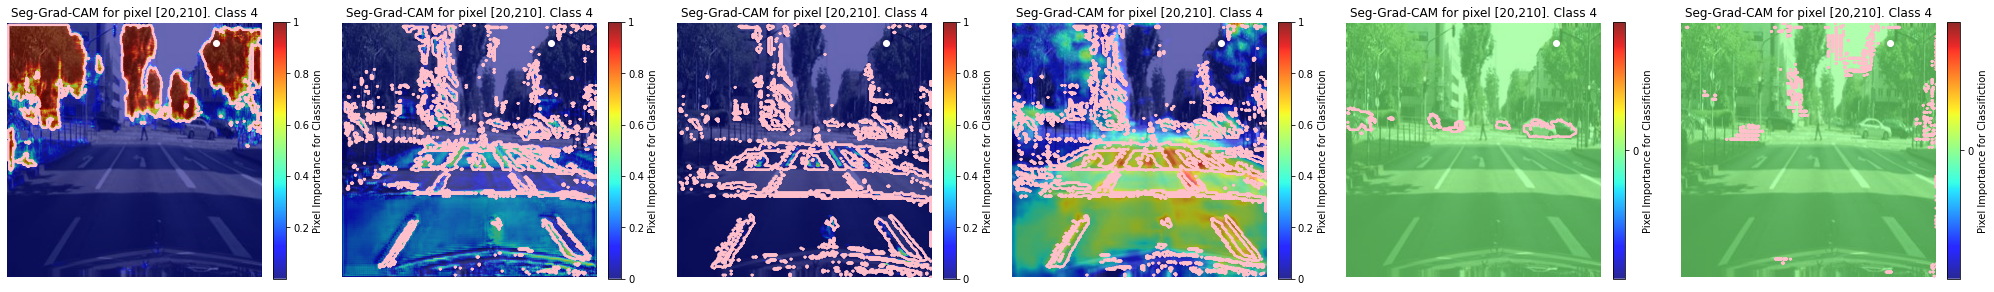

In [14]:
initial_weights = model.get_weights()
plt.figure(figsize=(35,35))
plt.subplot(1,6,1)
heatmap_random(m, -1, -1, 4)
plt.subplot(1,6,2)
heatmap_random(m, -1, -2, 4)
plt.subplot(1,6,3)
heatmap_random(m, -1, -5, 4)
plt.subplot(1,6,4)
heatmap_random(m, -1, -10, 4)
plt.subplot(1,6,5)
heatmap_random(m, -1, -15, 4)
plt.subplot(1,6,6)
heatmap_random(m, -1, -20, 4)